In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('seaborn-white')

### 1.loading the dataset

In [3]:
multiclass = pd.read_csv('../../dataset/multiclass_dataset_no_weird_obs.csv',header= 0)

In [4]:
data1, data2 =  train_test_split(multiclass, test_size=0.4, random_state=42,
                                              shuffle=True, stratify=None)
train1, test1  = train_test_split(data1, test_size=0.2, random_state=46,
                                              shuffle=True, stratify=None)
train2, test2  = train_test_split(data2, test_size=0.2, random_state=39,
                                              shuffle=True, stratify=None)
#data1.to_csv("multi_1.csv")

In [5]:
y_test = test1.iloc[:,17395]
x_train = np.array(train1.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1))
y_train = train1.iloc[:,17395]
x_test = np.array(test1.drop(['label','DepMap_ID','Unnamed: 0'], axis = 1))

In [6]:
y_train

114    4
219    6
571    7
595    4
845    0
      ..
964    7
546    8
676    2
875    0
38     3
Name: label, Length: 483, dtype: int64

### 2.Random Forest with the same parameters as in the RF.blood model

In [7]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight = "balanced",
                    bootstrap = True, oob_score = True)

In [8]:
rf.fit(x_train, y_train)
print('Training score: ', rf.score(x_train, y_train))
print('Test score: ', rf.score(x_test, y_test))

Training score:  1.0
Test score:  0.6363636363636364


In [9]:
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

The accuracy of the model is 63.6 %


In [10]:
#Create the vectors that contains the Cancers chosen (Cancer_Type2) and the one observed (Cancer_Type)
Cancer_Type = ["Gastrointestinal","Genitals","Muscle-Bone","Neuro","Breast","Head_Neck","Blood",
               "Genitourinary", "Lung"] 

In [11]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test).set_axis(Cancer_Type, axis = 1)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

In [12]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

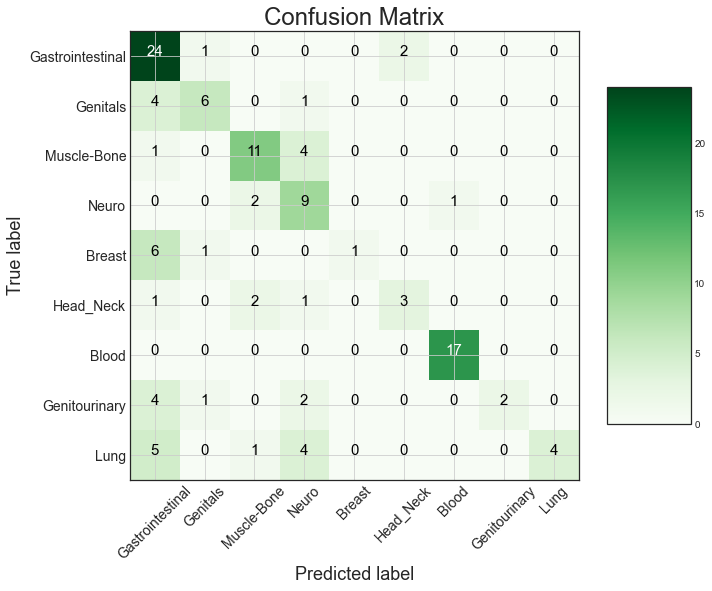

In [13]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### A model with different class weights

In [14]:
#let us compute the class frequencies loooking for some clues for balancing in a different way the classes
y_train_dummies = pd.get_dummies(y_train).set_axis(Cancer_Type, axis = 1)
y_train_dummies.sum()

Gastrointestinal    103
Genitals             46
Muscle-Bone          63
Neuro                69
Breast               18
Head_Neck            42
Blood                56
Genitourinary        28
Lung                 58
dtype: int64

In [15]:
rf_class_weighted = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight={0:1.05,1:3.1,2:1.9,3:1.65,4:11.5,5:2.3,6:2.5,7:5,8:2},
                    bootstrap = True, oob_score = True)

#class_weight={0:1.05,1:3.1,2:1.9,3:1.65,4:11.5,5:2.3,6:2.5,7:5,8:2}, Test score:  0.6776859504132231 almeno 1 in tutte le classi!
#class_weight={0:1.05,1:3.1,2:1.9,3:1.65,4:12.5,5:2.3,6:2.5,7:5,8:2}, Test score:  0.6694214876033058 almeno 1 in tutte le classi!

In [16]:
rf_class_weighted.fit(x_train, y_train)
print('Training score: ', rf_class_weighted.score(x_train, y_train))
print('Test score: ', rf_class_weighted.score(x_test, y_test))

Training score:  1.0
Test score:  0.6776859504132231


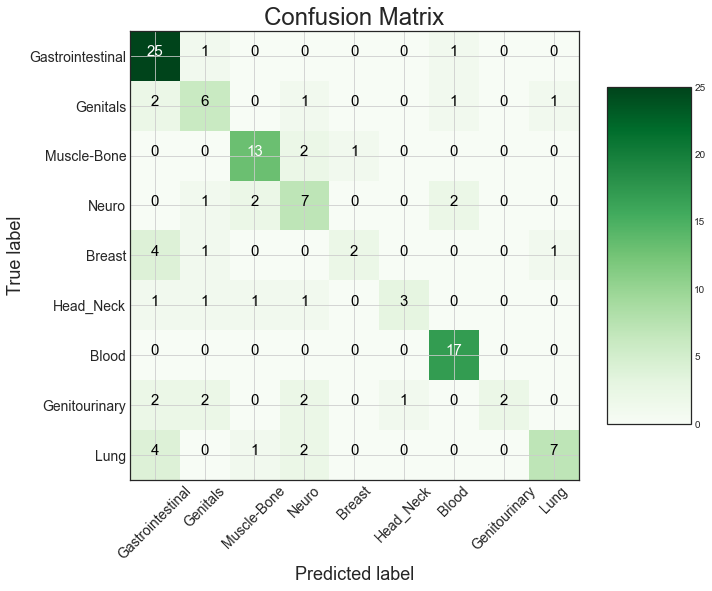

In [17]:
y_pred = rf_class_weighted.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Selection of the important features

In [18]:
out = cross_validate(rf_class_weighted, x_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

In [19]:
x_train_feature_impo = train1.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1)

feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = x_train_feature_impo.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.00001])
    
    
    
#altro metodo per feat_impo
# pd.DataFrame(out['estimator'][1].feature_importances_,
#                             index = x_train_feature_impo.columns,
#                             columns = ['Importance'.format(i+1)]).where(lambda x : x > 0.0005).dropna().index

In [21]:
# feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
# plt.title('Random Forest Feature Importance (Model n. 2)')
# #plt.xlabel('Features')
# #plt.show()

### New model using the remaining features

In [22]:
df0 = pd.DataFrame(feat_impo_all[0])
df1 = pd.DataFrame(feat_impo_all[1])
df2 = pd.DataFrame(feat_impo_all[2])
df3 = pd.DataFrame(feat_impo_all[3])
df4 = pd.DataFrame(feat_impo_all[4])

#consider the features that show up in all the 5 list of the important features
most_impo_feat = pd.concat([df0, df1, df2, df3, df4], axis = 1).dropna()  #219 features
genes = most_impo_feat.index

In [23]:
# use data2 split that has been done at the beginning
y_test_2 = test2.iloc[:,17395]
x_train_2 = np.array(train2.filter(genes, axis = 1))
y_train_2 = train2.iloc[:,17395]
x_test_2 = np.array(test2.filter(genes,axis = 1))

In [25]:
np.shape(x_train_2)

(322, 1681)

In [26]:
#balanced RF
rf.fit(x_train_2, y_train_2)
print('Training score: ', rf.score(x_train_2, y_train_2))
print('Test score: ', rf.score(x_test_2, y_test_2))

Training score:  1.0
Test score:  0.5555555555555556


In [27]:
#Same class weights as in the training
rf_class_weighted.fit(x_train_2, y_train_2)
print('Training score: ', rf_class_weighted.score(x_train_2, y_train_2))
print('Test score: ', rf_class_weighted.score(x_test_2, y_test_2))

Training score:  1.0
Test score:  0.5061728395061729


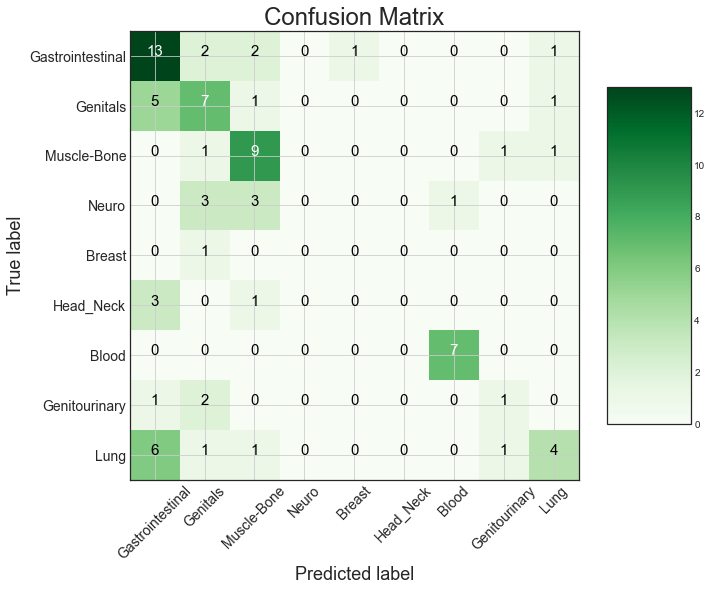

In [28]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test_2).set_axis(Cancer_Type, axis = 1)

y_pred = rf_class_weighted.predict(x_test_2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test_2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

In [235]:
rf_class_weighted2 = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight={0:1.95,1:5.7,2:3.7,3:4.5,4:12.5,5:16.5,6:3.5,7:10,8:3.924},
                    bootstrap = True, oob_score = True)

#class_weight={0:1.95,1:5.7,2:3.7,3:4.5,4:12.5,5:16.5,6:3.5,7:10,8:3.924}, Test score:  0.5802469135802469
#class_weight={0:2,1:6,2:3.7,3:4.5,4:12.5,5:16.5,6:3.5,7:10,8:3.924}, Test score:  0.5555555555555556 at least 1 obs for each class

In [236]:
#Same class weights as in the training
rf_class_weighted2.fit(x_train_2, y_train_2)
print('Training score: ', rf_class_weighted2.score(x_train_2, y_train_2))
print('Test score: ', rf_class_weighted2.score(x_test_2, y_test_2))

Training score:  1.0
Test score:  0.5802469135802469


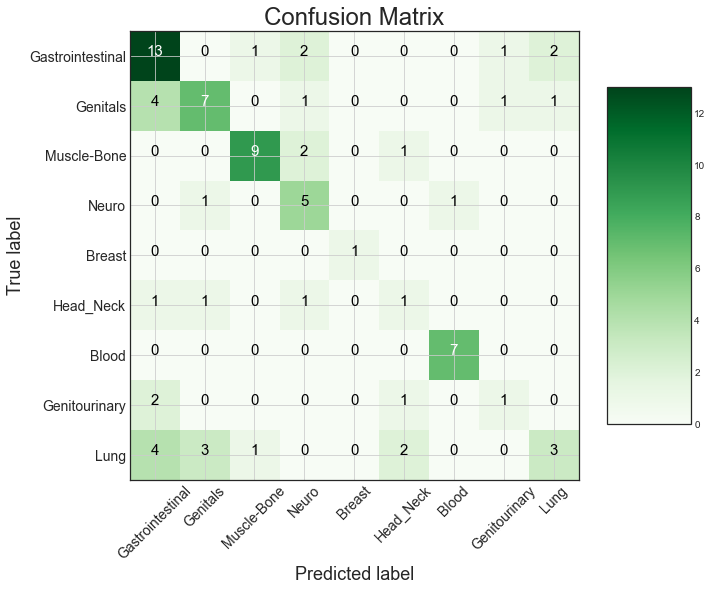

In [220]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test_2).set_axis(Cancer_Type, axis = 1)

y_pred = rf_class_weighted2.predict(x_test_2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test_2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Feature importance using Boruta algorithm

In [31]:
from boruta import BorutaPy

In [33]:
# Defining a general Random Forest Classifier
rf = RandomForestClassifier(random_state = 42, n_jobs = -1,
                    n_estimators = 500, max_depth = 20,
                    min_samples_split = 15, min_samples_leaf = 25,
                    class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf.fit(x_train, y_train)



RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=25, min_samples_split=15,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=42)

In [34]:
# Defining parameters of boruta object for feature selection
feat_selection = BorutaPy(rf, n_estimators = 'auto', verbose = 1, 
                        max_iter = 30, random_state = 2311)

# Get relevant features
feat_selection.fit(np.array(x_train), np.array(y_train))

Iteration: 1 / 30
Iteration: 2 / 30
Iteration: 3 / 30
Iteration: 4 / 30
Iteration: 5 / 30
Iteration: 6 / 30
Iteration: 7 / 30
Iteration: 8 / 30
Iteration: 9 / 30
Iteration: 10 / 30
Iteration: 11 / 30
Iteration: 12 / 30
Iteration: 13 / 30
Iteration: 14 / 30
Iteration: 15 / 30
Iteration: 16 / 30
Iteration: 17 / 30
Iteration: 18 / 30
Iteration: 19 / 30
Iteration: 20 / 30
Iteration: 21 / 30
Iteration: 22 / 30
Iteration: 23 / 30
Iteration: 24 / 30
Iteration: 25 / 30
Iteration: 26 / 30
Iteration: 27 / 30
Iteration: 28 / 30
Iteration: 29 / 30


BorutaPy finished running.

Iteration: 	30 / 30
Confirmed: 	61
Tentative: 	31
Rejected: 	17202


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                          max_depth=20, min_samples_leaf=25,
                                          min_samples_split=15, n_estimators=99,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x1AB89538440),
         max_iter=30, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1AB89538440, verbose=1)

In [85]:
# Selecting only selected features by using transform() function
# Creating list of varibale name, ranks, and final decision using zip
feat_rankings = pd.DataFrame(zip(x_train_feature_impo.columns,
                           feat_selection.ranking_,
                           feat_selection.support_))

In [90]:
feat_rankings = feat_rankings.sort_values(by = 1)
feat_rankings.iloc[60,2]

True

In [108]:
test2_boruta = test2.filter(feat_rankings[0].iloc[0:63], axis = 1)
train2_boruta = train2.filter(feat_rankings[0].iloc[0:63], axis = 1)

In [109]:
# use data2 split that has been done at the beginning
y_test_2 = test2.iloc[:,17395]
x_train_2 = np.array(train2_boruta)
y_train_2 = train2.iloc[:,17395]
x_test_2 = np.array(test2_boruta)

In [110]:
# Defining a general Random Forest Classifier
rf = RandomForestClassifier(random_state = 42, n_jobs = -1,
                    n_estimators = 500, 
                    bootstrap = True, oob_score = True)

In [111]:
rf.fit(x_train_2, y_train_2)
print('Training score: ', rf.score(x_train_2, y_train_2))
print('Test score: ', rf.score(x_test_2, y_test_2))

Training score:  1.0
Test score:  0.5679012345679012


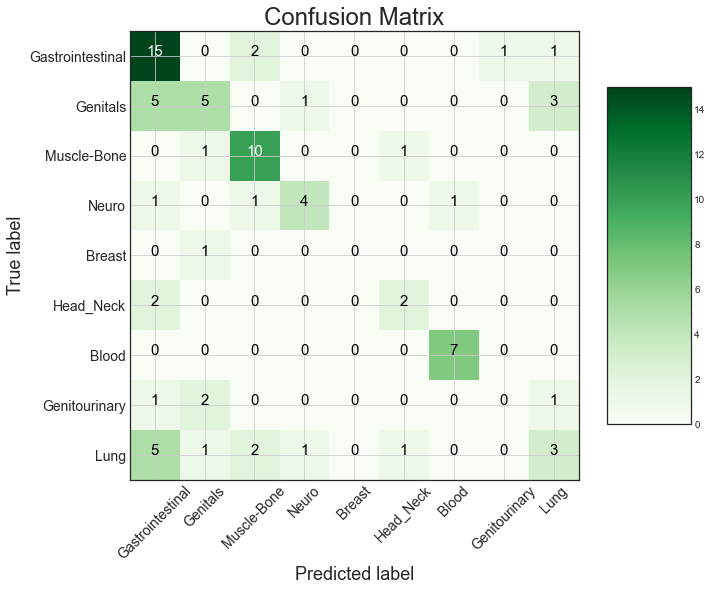

In [112]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test_2).set_axis(Cancer_Type, axis = 1)

y_pred = rf.predict(x_test_2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test_2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')